# 🚗 DFER-GCViT: Driver Facial Expression Recognition
## Efficient Fine-Tuning for Real-Time Automotive Applications

**Research Focus:** Full fine-tuning classification performance using the DFER-GCViT model.

**Author:** Syed Faizan Abbas Masood  
**Institution:** BTU Cottbus-Senftenberg

---

**Modified to use pre-trained model (Strategy 1) only.**

## 1️⃣ Setup & Installation

In [7]:
# Install required packages
%pip install -q numpy torch torchvision timm albumentations h5py opencv-python-headless tqdm pandas matplotlib seaborn scikit-learn

You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import time
import copy
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Other libraries
import h5py
import cv2
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"timm version: {timm.__version__}")

✓ All libraries imported successfully!
PyTorch version: 2.8.0
timm version: 1.0.24


In [9]:
# Device detection for Apple Silicon MPS
print(f"MPS available: {torch.backends.mps.is_available()}")
if torch.backends.mps.is_available():
    print("✓ Using Apple M3 Pro GPU (Metal)")
    device = torch.device('mps')
elif torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("⚠ Using CPU only")
    device = torch.device('cpu')

print(f"\n✓ Device: {device}")

MPS available: True
✓ Using Apple M3 Pro GPU (Metal)

✓ Device: mps


## 2️⃣ Data Upload & Extraction

In [11]:
# Set working directory
WORKING_DIR = '/Users/ar-syedfaizan.masood/Downloads/data-exploration'
os.chdir(WORKING_DIR)

print("="*70)
print("DATA UPLOAD")
print("="*70)

zip_path = os.path.join(WORKING_DIR, 'archive.zip')
if os.path.exists(zip_path):
    print("✓ archive.zip already exists!")
    size_mb = os.path.getsize(zip_path) / (1024 * 1024)
    print(f"  Size: {size_mb:.2f} MB")
else:
    print("❌ archive.zip not found!")
    print(f"   Expected at: {zip_path}")

DATA UPLOAD
✓ archive.zip already exists!
  Size: 60.32 MB


In [12]:
# Extract dataset
print("="*70)
print("DATA EXTRACTION")
print("="*70)

extract_path = os.path.join(WORKING_DIR, 'dataset')

if not os.path.exists(extract_path):
    print("\nExtracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✓ Extraction completed!")
else:
    print("✓ Dataset already extracted!")

# Find train and test directories
train_dir = None
test_dir = None

for root, dirs, files in os.walk(extract_path):
    for dir_name in dirs:
        if 'train' in dir_name.lower():
            train_dir = os.path.join(root, dir_name)
        elif 'test' in dir_name.lower():
            test_dir = os.path.join(root, dir_name)

print(f"\n✓ Train directory: {train_dir}")
print(f"✓ Test directory: {test_dir}")

# Get emotion classes
emotion_classes = sorted([d for d in os.listdir(train_dir)
                         if os.path.isdir(os.path.join(train_dir, d))])

print(f"\n✓ Emotion classes ({len(emotion_classes)}): {emotion_classes}")

# Create label mappings
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotion_classes)}
label_to_emotion = {idx: emotion for emotion, idx in emotion_to_label.items()}

print("\n📊 Emotion to Label Mapping:")
for emotion, label in emotion_to_label.items():
    print(f"  {emotion}: {label}")

DATA EXTRACTION

Extracting dataset...
✓ Extraction completed!

✓ Train directory: /Users/ar-syedfaizan.masood/Downloads/data-exploration/dataset/train
✓ Test directory: /Users/ar-syedfaizan.masood/Downloads/data-exploration/dataset/test

✓ Emotion classes (7): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

📊 Emotion to Label Mapping:
  angry: 0
  disgust: 1
  fear: 2
  happy: 3
  neutral: 4
  sad: 5
  surprise: 6


## 3️⃣ HDF5 Dataset Creation

In [14]:
# Helper functions for HDF5 creation

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess image"""
    try:
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(target_size, Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        return img
    except Exception as e:
        print(f"⚠️ Error: {e}")
        return None

def collect_image_paths(data_dir, emotion_classes, emotion_to_label):
    """Collect all image paths and labels"""
    image_paths = []
    labels = []
    filenames = []

    for emotion in emotion_classes:
        emotion_path = os.path.join(data_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue

        label = emotion_to_label[emotion]

        for img_name in os.listdir(emotion_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(emotion_path, img_name)
                image_paths.append(img_path)
                labels.append(label)
                filenames.append(f"{emotion}/{img_name}")

    return image_paths, labels, filenames

def create_hdf5_dataset(data_dir, h5_path, emotion_classes, emotion_to_label,
                        target_size=(224, 224), batch_size=100):
    """Create HDF5 file from image directory"""

    print(f"\nCreating: {h5_path}")
    image_paths, labels, filenames = collect_image_paths(data_dir, emotion_classes, emotion_to_label)
    total_images = len(image_paths)
    print(f"Found {total_images} images")
    img_shape = (target_size[1], target_size[0], 3)

    with h5py.File(h5_path, 'w') as h5f:
        images_dataset = h5f.create_dataset('images', shape=(total_images, *img_shape),
            dtype=np.float32, chunks=(1, *img_shape), compression='gzip', compression_opts=4)
        labels_dataset = h5f.create_dataset('labels', shape=(total_images,), dtype=np.int32)
        filenames_dataset = h5f.create_dataset('filenames', shape=(total_images,),
            dtype=h5py.string_dtype(encoding='utf-8'))

        h5f.attrs['num_classes'] = len(emotion_classes)
        h5f.attrs['emotion_classes'] = emotion_classes
        h5f.attrs['image_shape'] = img_shape
        h5f.attrs['target_size'] = target_size
        h5f.attrs['total_images'] = total_images

        num_batches = (total_images + batch_size - 1) // batch_size
        processed = 0

        for batch_idx in tqdm(range(num_batches), desc="Processing"):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, total_images)

            batch_paths = image_paths[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]
            batch_filenames = filenames[start_idx:end_idx]

            batch_images = []
            valid_indices = []

            for i, img_path in enumerate(batch_paths):
                img = load_and_preprocess_image(img_path, target_size)
                if img is not None:
                    batch_images.append(img)
                    valid_indices.append(start_idx + i)

            if batch_images:
                batch_images = np.array(batch_images, dtype=np.float32)
                for i, global_idx in enumerate(valid_indices):
                    images_dataset[global_idx] = batch_images[i]
                    labels_dataset[global_idx] = batch_labels[i]
                    filenames_dataset[global_idx] = batch_filenames[i]
                processed += len(batch_images)

    print(f"✓ Created: {h5_path}")
    print(f"✓ Images: {processed}/{total_images}")
    return processed

print("✓ HDF5 creation functions defined!")

✓ HDF5 creation functions defined!


In [15]:
# Create HDF5 files
print("="*70)
print("CREATING HDF5 FILES")
print("="*70)

TARGET_SIZE = (224, 224)
BATCH_SIZE_HDF5 = 100

train_h5_path = os.path.join(WORKING_DIR, 'kmu_fed_train.h5')
test_h5_path = os.path.join(WORKING_DIR, 'kmu_fed_test.h5')
config_path = os.path.join(WORKING_DIR, 'kmu_fed_config.json')

if os.path.exists(train_h5_path) and os.path.exists(test_h5_path):
    print("✓ HDF5 files already exist, skipping creation...")
    with open(config_path, 'r') as f:
        config = json.load(f)
    train_count = config['train_total']
    test_count = config['test_total']
else:
    print("\n📦 TRAINING SET:")
    train_count = create_hdf5_dataset(data_dir=train_dir, h5_path=train_h5_path,
        emotion_classes=emotion_classes, emotion_to_label=emotion_to_label,
        target_size=TARGET_SIZE, batch_size=BATCH_SIZE_HDF5)

    print("\n📦 TEST SET:")
    test_count = create_hdf5_dataset(data_dir=test_dir, h5_path=test_h5_path,
        emotion_classes=emotion_classes, emotion_to_label=emotion_to_label,
        target_size=TARGET_SIZE, batch_size=BATCH_SIZE_HDF5)

    config = {
        'train_h5_path': train_h5_path, 'test_h5_path': test_h5_path,
        'emotion_classes': emotion_classes, 'emotion_to_label': emotion_to_label,
        'label_to_emotion': label_to_emotion, 'num_classes': len(emotion_classes),
        'target_size': TARGET_SIZE, 'train_total': train_count,
        'test_total': test_count, 'total_images': train_count + test_count
    }
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)

print("\n📊 Summary:")
print(f"  Training images: {train_count}")
print(f"  Test images: {test_count}")
print(f"  Classes: {len(emotion_classes)}")

CREATING HDF5 FILES
✓ HDF5 files already exist, skipping creation...

📊 Summary:
  Training images: 28709
  Test images: 7178
  Classes: 7


## 4️⃣ DataLoader & Augmentation

In [16]:
# Custom Dataset Class
class KMUFEDDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform
        with h5py.File(h5_path, 'r') as h5f:
            self.num_samples = h5f['images'].shape[0]
            self.emotion_classes = list(h5f.attrs['emotion_classes'])
            self.num_classes = h5f.attrs['num_classes']

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as h5f:
            image = h5f['images'][idx]
            label = h5f['labels'][idx]
            image = (image * 255).astype(np.uint8)
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            else:
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            label = torch.tensor(label, dtype=torch.long)
            return image, label

print("✓ Dataset class defined!")

✓ Dataset class defined!


In [17]:
# Data Augmentation Transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    ToTensorV2()
])

print("✓ Transforms defined!")

✓ Transforms defined!


In [18]:
# Create Datasets and DataLoaders
with open(config_path, 'r') as f:
    config = json.load(f)

train_dataset = KMUFEDDataset(h5_path=config['train_h5_path'], transform=train_transform)
test_dataset = KMUFEDDataset(h5_path=config['test_h5_path'], transform=test_transform)

BATCH_SIZE = 16
NUM_WORKERS = 0  # macOS compatibility
PIN_MEMORY = False if device.type == 'mps' else True

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

print("✓ DataLoaders created!")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ DataLoaders created!
  Training batches: 1794
  Test batches: 449


In [19]:
# Calculate class weights
def count_class_distribution(dataloader):
    label_counts = torch.zeros(config['num_classes'], dtype=torch.long)
    for _, labels in tqdm(dataloader, desc="Counting classes"):
        for label in labels:
            label_counts[label] += 1
    return label_counts

train_dist = count_class_distribution(train_loader)
class_weights = 1.0 / train_dist.float()
class_weights = class_weights / class_weights.sum() * config['num_classes']
class_weights = class_weights.to(device)

print("\n⚖️ Class Weights:")
for idx, weight in enumerate(class_weights):
    emotion = config['emotion_classes'][idx]
    print(f"  {emotion}: {weight:.4f}")

Counting classes: 100%|██████████| 1794/1794 [00:52<00:00, 34.18it/s]


⚖️ Class Weights:
  angry: 0.4800
  disgust: 4.3979
  fear: 0.4680
  happy: 0.2658
  neutral: 0.3863
  sad: 0.3972
  surprise: 0.6049


## 5️⃣ Model Architecture

In [20]:
# Modified Classifier Head
class ModifiedClassifierHead(nn.Module):
    def __init__(self, in_features, hidden_features=256, num_classes=6, dropout=0.5):
        super(ModifiedClassifierHead, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_features, num_classes)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# DFER-GCViT Model
class DFER_GCViT(nn.Module):
    def __init__(self, model_name='gcvit_small', num_classes=6,
                 hidden_features=256, dropout=0.5, pretrained=True):
        super(DFER_GCViT, self).__init__()
        self.model_name = model_name
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.classifier = ModifiedClassifierHead(in_features=self.feature_dim,
            hidden_features=hidden_features, num_classes=num_classes, dropout=dropout)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True

    def freeze_all_except_last_n_blocks(self, n_blocks=2):
        self.freeze_backbone()
        all_params = list(self.backbone.parameters())
        num_params = len(all_params)
        unfreeze_from = max(0, num_params - n_blocks * 10)
        for param in all_params[unfreeze_from:]:
            param.requires_grad = True

def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

print("✓ Model classes defined!")

✓ Model classes defined!


In [21]:
# Test model creation
MODEL_NAME = 'gcvit_small'
NUM_CLASSES = config['num_classes']
HIDDEN_FEATURES = 256
DROPOUT = 0.5

print("Creating test model...")
test_model = DFER_GCViT(model_name=MODEL_NAME, num_classes=NUM_CLASSES,
    hidden_features=HIDDEN_FEATURES, dropout=DROPOUT, pretrained=True).to(device)

trainable, total = count_parameters(test_model)
print(f"\n✓ Model created!")
print(f"  Total parameters: {total:,}")
print(f"  Trainable: {trainable:,} ({trainable/total*100:.2f}%)")

dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = test_model(dummy_input)
print(f"\n✓ Forward pass successful!")

del test_model
if device.type == 'mps':
    torch.mps.empty_cache()

Creating test model...

✓ Model created!
  Total parameters: 50,522,348
  Trainable: 50,522,348 (100.00%)

✓ Forward pass successful!


## 6️⃣ Training Configuration & Functions

In [22]:
# Training Configuration
TRAINING_CONFIG = {
    'epochs': 60,  # Change to 2-5 for quick testing
    'learning_rate': 0.0001,
    'weight_decay': 1e-4,
    'patience': 30,
    'min_delta': 0.001
}

print("📋 Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

📋 Training Configuration:
  epochs: 60
  learning_rate: 0.0001
  weight_decay: 0.0001
  patience: 30
  min_delta: 0.001


In [23]:
# Training Helper Classes and Functions

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'loss': loss.item()})
    epoch_loss = running_loss / len(dataloader.dataset)
    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss, metrics

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'loss': loss.item()})
    epoch_loss = running_loss / len(dataloader.dataset)
    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss, metrics, all_labels, all_preds

print("✓ Training functions defined!")

✓ Training functions defined!


In [25]:
# Main Training Function

def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, num_epochs, device, strategy_name):
    print(f"\n{'='*70}")
    print(f"TRAINING: {strategy_name}")
    print(f"{'='*70}\n")

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    best_val_acc = 0.0
    best_model_state = None
    early_stopping = EarlyStopping(patience=TRAINING_CONFIG['patience'])

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 70)

        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_metrics, _, _ = validate(model, test_loader, criterion, device)

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        epoch_time = time.time() - epoch_start
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['epoch_times'].append(epoch_time)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_metrics['accuracy']:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Acc: {val_metrics['accuracy']:.4f}")
        print(f"Time: {epoch_time:.2f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"✓ New best: {best_val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break
        print()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"✓ Training completed!")
    print(f"  Best Val Accuracy: {best_val_acc:.4f}")
    return history, best_model_state

print("✓ Main training function defined!")

✓ Main training function defined!


## 7️⃣ Load Pre-trained Model & Evaluate

In [26]:
# Strategy: Full Fine-Tuning Only
# Using pre-trained model instead of retraining
strategy_name = 'Strategy 1: Full Fine-Tuning'

all_results = {}
all_predictions = {}

print("="*70)
print("LOADING PRE-TRAINED MODEL")
print("="*70)


LOADING PRE-TRAINED MODEL


In [27]:
# Load pre-trained model and evaluate
strategy_name = 'Strategy 1: Full Fine-Tuning'
strategy_config = {'freeze_backbone': False, 'unfreeze_blocks': None}

print(f"\n\n{'='*70}")
print(f"🚀 {strategy_name} - Loading Pre-trained Model")
print(f"{'='*70}")

# Create model architecture
model = DFER_GCViT(model_name=MODEL_NAME, num_classes=NUM_CLASSES,
    hidden_features=HIDDEN_FEATURES, dropout=DROPOUT, pretrained=True).to(device)

trainable, total = count_parameters(model)
print(f"\nModel architecture loaded")
print(f"Total parameters: {total:,}")

# Load the pre-trained checkpoint
checkpoint_path = os.path.join(WORKING_DIR, 'model_Strategy_1_Full_Fine-Tuning.pth')
print(f"\nLoading checkpoint from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
history = checkpoint['history']
saved_metrics = checkpoint['test_metrics']

print("✓ Model loaded successfully!")

# Setup criterion for evaluation
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Run final evaluation on test set
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

test_loss, test_metrics, y_true, y_pred = validate(model, test_loader, criterion, device)

print(f"\n📊 Test Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")

# Store results
all_results[strategy_name] = {
    'history': history,
    'test_metrics': test_metrics,
    'trainable_params': trainable,
    'total_params': total,
    'avg_epoch_time': np.mean(history['epoch_times'])
}
all_predictions[strategy_name] = {'y_true': y_true, 'y_pred': y_pred}

print("\n\n" + "="*70)
print("✅ EVALUATION COMPLETED!")
print("="*70)

# Clean up
del model
if device.type == 'mps':
    torch.mps.empty_cache()




🚀 Strategy 1: Full Fine-Tuning - Loading Pre-trained Model

Model architecture loaded
Total parameters: 50,522,348

Loading checkpoint from: /Users/ar-syedfaizan.masood/Downloads/data-exploration/model_Strategy_1_Full_Fine-Tuning.pth
✓ Model loaded successfully!

EVALUATING ON TEST SET



📊 Test Results:
  Accuracy:  0.7175
  Precision: 0.7155
  Recall:    0.7175
  F1-Score:  0.7156


✅ EVALUATION COMPLETED!


## 8️⃣ Results Summary

In [28]:
# Display Results Summary
print("="*70)
print("FINAL RESULTS - Strategy 1: Full Fine-Tuning")
print("="*70)

results = all_results[strategy_name]
print(f"\n📊 Model Performance:")
print(f"  Accuracy:     {results['test_metrics']['accuracy']:.4f}")
print(f"  Precision:    {results['test_metrics']['precision']:.4f}")
print(f"  Recall:       {results['test_metrics']['recall']:.4f}")
print(f"  F1-Score:     {results['test_metrics']['f1_score']:.4f}")
print(f"  Total Params: {results['total_params']:,}")
print(f"  Avg Epoch Time: {results['avg_epoch_time']:.2f}s")


FINAL RESULTS - Strategy 1: Full Fine-Tuning

📊 Model Performance:
  Accuracy:     0.7175
  Precision:    0.7155
  Recall:       0.7175
  F1-Score:     0.7156
  Total Params: 50,522,348
  Avg Epoch Time: 1372.90s


## 9️⃣ Loss Curves

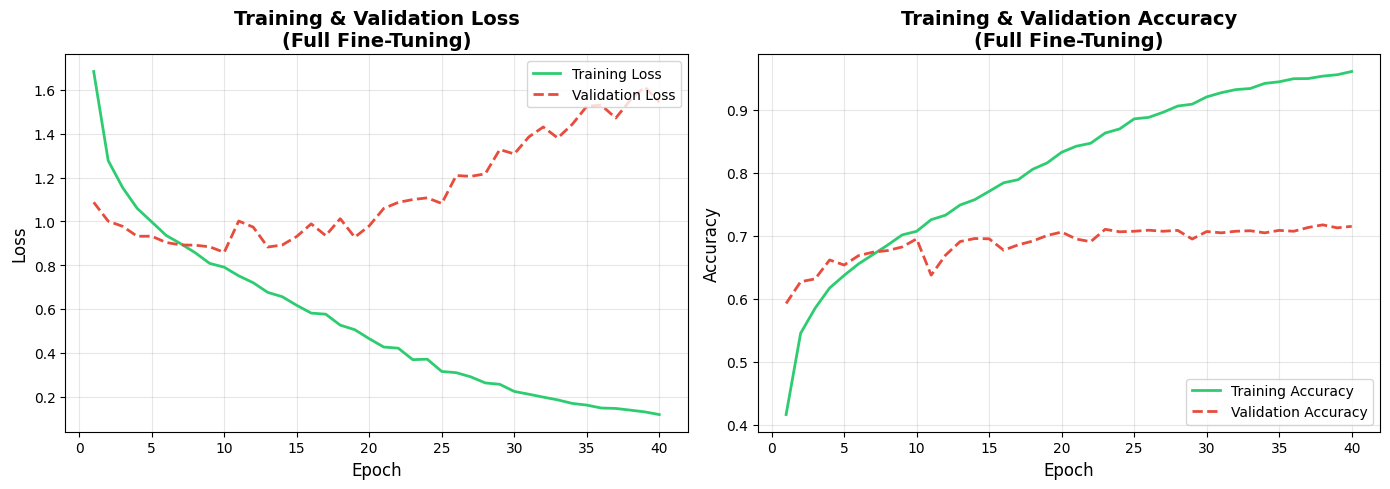

✓ Loss curves saved!


In [31]:
# Plot Loss Curves for Full Fine-Tuning Strategy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

history = all_results[strategy_name]['history']
epochs = range(1, len(history['train_loss']) + 1)

# Training and Validation Loss
axes[0].plot(epochs, history['train_loss'], '-', color='#2ecc71', 
             label='Training Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], '--', color='#e74c3c', 
             label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss\n(Full Fine-Tuning)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Training and Validation Accuracy
axes[1].plot(epochs, history['train_acc'], '-', color='#2ecc71', 
             label='Training Accuracy', linewidth=2)
axes[1].plot(epochs, history['val_acc'], '--', color='#e74c3c', 
             label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy\n(Full Fine-Tuning)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'loss_curves_full_finetuning.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Loss curves saved!")


## 🔟 Confusion Matrix

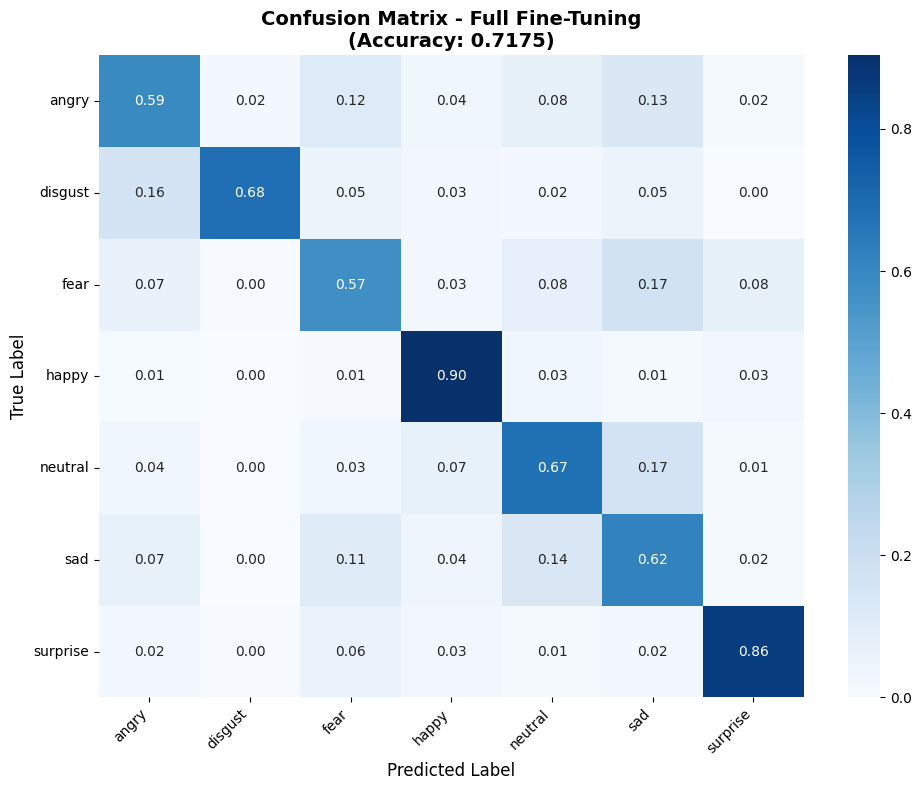

✓ Confusion matrix saved!


In [32]:
# Plot Confusion Matrix for Full Fine-Tuning Strategy
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

predictions = all_predictions[strategy_name]
cm = confusion_matrix(predictions['y_true'], predictions['y_pred'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=config['emotion_classes'],
            yticklabels=config['emotion_classes'],
            ax=ax, cbar=True)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix - Full Fine-Tuning\n(Accuracy: {all_results[strategy_name]["test_metrics"]["accuracy"]:.4f})', 
             fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'confusion_matrix_full_finetuning.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Confusion matrix saved!")


## 1️⃣1️⃣ Performance Summary Chart

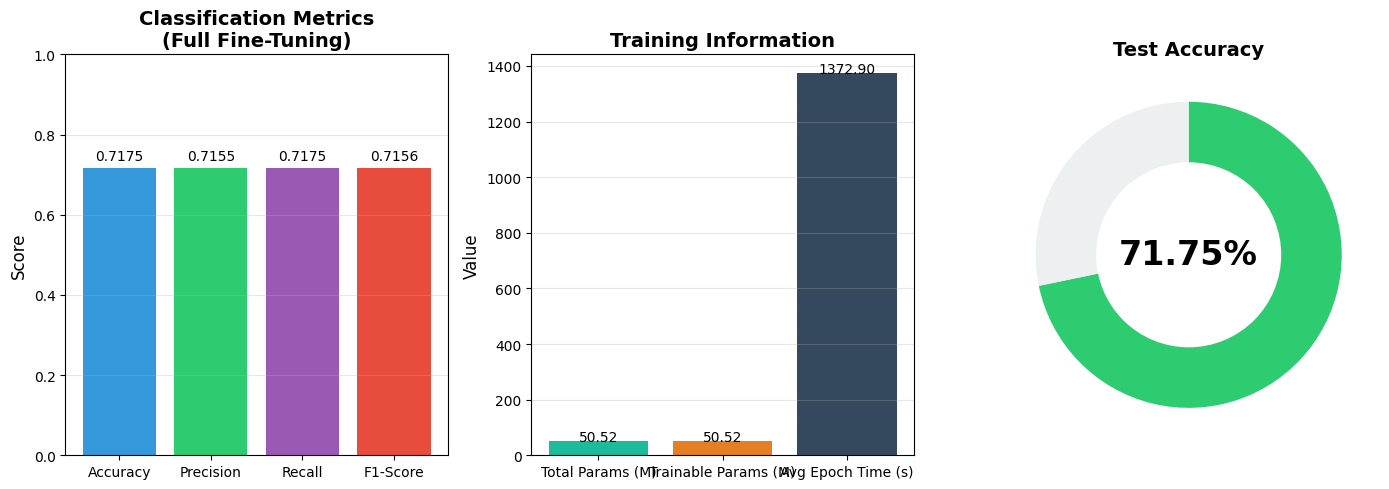

✓ Performance summary chart saved!


In [33]:
# Performance Summary Chart
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Get results
results = all_results[strategy_name]
metrics = results['test_metrics']

# Bar chart for classification metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]

colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
bars = axes[0].bar(metric_names, metric_values, color=colors)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Classification Metrics\n(Full Fine-Tuning)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, metric_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.4f}', ha='center', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Training info
info_labels = ['Total Params (M)', 'Trainable Params (M)', 'Avg Epoch Time (s)']
info_values = [results['total_params']/1e6, results['trainable_params']/1e6, results['avg_epoch_time']]
bars2 = axes[1].bar(info_labels, info_values, color=['#1abc9c', '#e67e22', '#34495e'])
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Training Information', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, info_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{val:.2f}', ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')

# Accuracy gauge-style visualization
axes[2].pie([metrics['accuracy'], 1-metrics['accuracy']], 
            colors=['#2ecc71', '#ecf0f1'],
            startangle=90, counterclock=False)
circle = plt.Circle((0, 0), 0.6, color='white')
axes[2].add_artist(circle)
axes[2].text(0, 0, f"{metrics['accuracy']:.2%}", ha='center', va='center', fontsize=24, fontweight='bold')
axes[2].set_title('Test Accuracy', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, 'performance_summary.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Performance summary chart saved!")


## 1️⃣2️⃣ Save Results

In [34]:
# Save final results
results = all_results[strategy_name]
results_to_save = {
    strategy_name: {
        'test_metrics': results['test_metrics'],
        'trainable_params': results['trainable_params'],
        'total_params': results['total_params'],
        'avg_epoch_time': results['avg_epoch_time']
    }
}

results_path = os.path.join(WORKING_DIR, 'final_results.json')
with open(results_path, 'w') as f:
    json.dump(results_to_save, f, indent=4)

print("✓ Results saved to:", results_path)

# Print final summary
print("\n" + "="*70)
print("📊 FINAL SUMMARY - Full Fine-Tuning Strategy")
print("="*70)
print(f"\n  Test Accuracy:  {results['test_metrics']['accuracy']:.4f}")
print(f"  Test F1-Score:  {results['test_metrics']['f1_score']:.4f}")
print(f"  Total Params:   {results['total_params']:,}")
print(f"  Avg Epoch Time: {results['avg_epoch_time']:.2f}s")
print("\n" + "="*70)


✓ Results saved to: /Users/ar-syedfaizan.masood/Downloads/data-exploration/final_results.json

📊 FINAL SUMMARY - Full Fine-Tuning Strategy

  Test Accuracy:  0.7175
  Test F1-Score:  0.7156
  Total Params:   50,522,348
  Avg Epoch Time: 1372.90s



---

# 🎓 Research Complete!

**Author:** Syed Faizan Abbas Masood  
**Institution:** BTU Cottbus-Senftenberg